In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import skimage
#%matplotlib inline
%pylab inline
import os
import sys
from time import time
from glob import glob
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration, run

Populating the interactive namespace from numpy and matplotlib


In [2]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y

In [3]:
def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))
        
def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [4]:
def features_extractor(tile, params, extractor, threshold):
    if params['preprocessing']['polarity']==-1:
        tile = 255-tile
    min_std=params['preprocessing']['min_std']
    _std = np.std(tile.flatten())

    extracted = []
    if _std < min_std:
        extracted.append([0] * 1981)
    else:
        Stats = extractor.segment_cells(tile)
        cells = extractor.extract_blobs(Stats,tile)
        cells = pd.DataFrame(cells)
        cells = cells[cells['padded_patch'].notnull()]
        cells = cells.drop(['padded_patch','left','top'],1)
        cells = np.asarray(cells)
        for k in range(len(cells)):
            cells[k][0] = cells[k][0][:10]
        origin = np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1)
        for k in range(origin.shape[1]):
            x, y = CDF(origin[:,k])
            ten = [y[np.argmin(np.absolute(x-threshold[k][j]))] for j in range(99)]
            extracted.extend(ten)
        extracted.extend([cells.shape[0]])
    return extracted

In [5]:
stack = 'MD594'
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}

fn = 'CSHL_data_processed/MD589/ThresholdsV2.pkl'
setup_download_from_s3(fn, recursive=False)
thresholds = pickle.load(open(os.environ['ROOT_DIR']+fn,'rb'))

fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


In [6]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1
num_round = 100

In [7]:
yamlfile=os.environ['REPO_DIR']+'shape_params.yaml'
params=configuration(yamlfile).getParams()

cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V2/MD589/'
cell2_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V2/MD585/'
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
features_fn = 'CSHL_grid_features/'
if not os.path.exists(os.environ['ROOT_DIR']+features_fn):
    os.mkdir(os.environ['ROOT_DIR']+features_fn)
features_fn = features_fn+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+features_fn):
    os.mkdir(os.environ['ROOT_DIR']+features_fn)

savepath = 'CSHL_scoremaps_new/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)
savepath = savepath+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)

paired_structures = ['5N', '6N', '7N', '7nn', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures
window_size = 224

/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))


In [8]:
%%time
section = 200
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape
extractor = patch_extractor(params)

ALREADY DOWNLOADED FILE
CPU times: user 807 ms, sys: 935 ms, total: 1.74 s
Wall time: 2.83 s


In [9]:
%%time
stride = int(30/0.46)
polygons = [(contour['name'], contour['vertices']) \
                for contour_id, contour in contours_grouped.get_group(section).iterrows()]
xs, ys = np.meshgrid(np.arange(0, n, stride), np.arange(0, m, stride), indexing='xy')
locations = np.c_[xs.flat, ys.flat]
valid_structure = {}
for contour_id, contour in polygons:
    valid_structure[contour_id] = contour

CPU times: user 4.75 ms, sys: 3.15 ms, total: 7.9 ms
Wall time: 19.6 ms


In [10]:
valid_structure.keys()

dict_keys(['SC', 'Pn', 'Sp5C', 'IO', 'Tz', 'VTA', 'RtTg', '7n', 'RMC', 'IC'])

In [60]:
15400*(112/65)**2

45722.508875739644

In [58]:
len(locations)

45315

In [11]:
len(grid_features)

NameError: name 'grid_features' is not defined

In [ ]:
%%time
grid_features = {}
for i in range(len(locations)):
    print(i, len(locations))
    left = locations[i][0]
    right = int(min(left + window_size, n))
    up = locations[i][1]
    down = int(min(up + window_size, m))
    tile = img[up:down, left:right]
    grid_index = str(section)+'_'+str(left)+'_'+str(up)
    try:
        extracted = features_extractor(tile, params, extractor, thresholds)
        grid_features[grid_index] = extracted
    except:
        continue

0 45315
1 45315
2 45315
3 45315
4 45315
5 45315
6 45315
7 45315
8 45315
9 45315
10 45315
11 45315
12 45315
13 45315
14 45315
15 45315
16 45315
17 45315
18 45315
19 45315
20 45315
21 45315
22 45315
23 45315
24 45315
25 45315
26 45315
27 45315
28 45315
29 45315
30 45315
31 45315
32 45315
33 45315
34 45315
35 45315
36 45315
37 45315
38 45315
39 45315
40 45315
41 45315
42 45315
43 45315
44 45315
45 45315
46 45315
47 45315
48 45315
49 45315
50 45315
51 45315
52 45315
53 45315
54 45315
55 45315
56 45315
57 45315
58 45315
59 45315
60 45315
61 45315
62 45315
63 45315
64 45315
65 45315
66 45315
67 45315
68 45315
69 45315
70 45315
71 45315
72 45315
73 45315
74 45315
75 45315
76 45315
77 45315
78 45315
79 45315
80 45315
81 45315
82 45315
83 45315
84 45315
85 45315
86 45315
87 45315
88 45315
89 45315
90 45315
91 45315
92 45315
93 45315
94 45315
95 45315
96 45315
97 45315
98 45315
99 45315
100 45315
101 45315
102 45315
103 45315
104 45315
105 45315
106 45315
107 45315
108 45315
109 45315
110 45315


831 45315
832 45315
833 45315
834 45315
835 45315
836 45315
837 45315
838 45315
839 45315
840 45315
841 45315
842 45315
843 45315
844 45315
845 45315
846 45315
847 45315
848 45315
849 45315
850 45315
851 45315
852 45315
853 45315
854 45315
855 45315
856 45315
857 45315
858 45315
859 45315
860 45315
861 45315
862 45315
863 45315
864 45315
865 45315
866 45315
867 45315
868 45315
869 45315
870 45315
871 45315
872 45315
873 45315
874 45315
875 45315
876 45315
877 45315
878 45315
879 45315
880 45315
881 45315
882 45315
883 45315
884 45315
885 45315
886 45315
887 45315
888 45315
889 45315
890 45315
891 45315
892 45315
893 45315
894 45315
895 45315
896 45315
897 45315
898 45315
899 45315
900 45315
901 45315
902 45315
903 45315
904 45315
905 45315
906 45315
907 45315
908 45315
909 45315
910 45315
911 45315
912 45315
913 45315
914 45315
915 45315
916 45315
917 45315
918 45315
919 45315
920 45315
921 45315
922 45315
923 45315
924 45315
925 45315
926 45315
927 45315
928 45315
929 45315
930 45315


1592 45315
1593 45315
1594 45315
1595 45315
1596 45315
1597 45315
1598 45315
1599 45315
1600 45315
1601 45315
1602 45315
1603 45315
1604 45315
1605 45315
1606 45315
1607 45315
1608 45315
1609 45315
1610 45315
1611 45315
1612 45315
1613 45315
1614 45315
1615 45315
1616 45315
1617 45315
1618 45315
1619 45315
1620 45315
1621 45315
1622 45315
1623 45315
1624 45315
1625 45315
1626 45315
1627 45315
1628 45315
1629 45315
1630 45315
1631 45315
1632 45315
1633 45315
1634 45315
1635 45315
1636 45315
1637 45315
1638 45315
1639 45315
1640 45315
1641 45315
1642 45315
1643 45315
1644 45315
1645 45315
1646 45315
1647 45315
1648 45315
1649 45315
1650 45315
1651 45315
1652 45315
1653 45315
1654 45315
1655 45315
1656 45315
1657 45315
1658 45315
1659 45315
1660 45315
1661 45315
1662 45315
1663 45315
1664 45315
1665 45315
1666 45315
1667 45315
1668 45315
1669 45315
1670 45315
1671 45315
1672 45315
1673 45315
1674 45315
1675 45315
1676 45315
1677 45315
1678 45315
1679 45315
1680 45315
1681 45315
1682 45315

2386 45315
2387 45315
2388 45315
2389 45315
2390 45315
2391 45315
2392 45315
2393 45315
2394 45315
2395 45315
2396 45315
2397 45315
2398 45315
2399 45315
2400 45315
2401 45315
2402 45315
2403 45315
2404 45315
2405 45315
2406 45315
2407 45315
2408 45315
2409 45315
2410 45315
2411 45315
2412 45315
2413 45315
2414 45315
2415 45315
2416 45315
2417 45315
2418 45315
2419 45315
2420 45315
2421 45315
2422 45315
2423 45315
2424 45315
2425 45315
2426 45315
2427 45315
2428 45315
2429 45315
2430 45315
2431 45315
2432 45315
2433 45315
2434 45315
2435 45315
2436 45315
2437 45315
2438 45315
2439 45315
2440 45315
2441 45315
2442 45315
2443 45315
2444 45315
2445 45315
2446 45315
2447 45315
2448 45315
2449 45315
2450 45315
2451 45315
2452 45315
2453 45315
2454 45315
2455 45315
2456 45315
2457 45315
2458 45315
2459 45315
2460 45315
2461 45315
2462 45315
2463 45315
2464 45315
2465 45315
2466 45315
2467 45315
2468 45315
2469 45315
2470 45315
2471 45315
2472 45315
2473 45315
2474 45315
2475 45315
2476 45315

In [33]:
%%time
for structure in all_structures:
    if structure not in valid_structure.keys():
        continue
    print(structure)
    subpath = savepath + structure + '/'
    if not os.path.exists(os.environ['ROOT_DIR']+subpath):
        os.mkdir(os.environ['ROOT_DIR']+subpath)
    
    fp =[]
    fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl') 
    fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1-state]*len(clouds))
    
    fp =[]
    fp.append(cell2_dir+structure+'/MD585_'+structure+'_positive.pkl') 
    fp.append(cell2_dir+structure+'/MD585_'+structure+'_negative.pkl') 
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1-state]*len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'
    
    scoremap = np.zeros([m,n])
    for x,y in locations:
        try:
            grid_index = str(section)+'_'+str(x)+'_'+str(y)
            feature_vector = grid_features[grid_index]
            xtest = xgb.DMatrix(feature_vector)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            origin = scoremap[y:y+window_size, x:x+window_size]
            comp = np.absolute(origin) - np.absolute(score)
            scoremap[y:y+window_size, x:x+window_size] = origin * (comp > 0) + score * (comp < 0)
        except:
            continue
    scoremap = 1 / (1+np.exp(-scoremap))
#     scoremap = (scoremap - scoremap.min()) / (scoremap.max() - scoremap.min())
    gray = scoremap * 255
    gray = gray.astype(np.uint8)
    if structure in valid_structure.keys():
        polygon = valid_structure[structure]
        rgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
        com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 15, lineType=8)
    else:
        com = gray
    filename = subpath + structure + '_' + str(section) + '.tif'
    cv2.imwrite(os.environ['ROOT_DIR']+filename, com)

Pn
Tz
RMC
Sp5C
RtTg
SC
IC
CPU times: user 7min 23s, sys: 56.7 s, total: 8min 20s
Wall time: 6min 55s


In [30]:
a = np.array([[0, 1], [1, 0]])
1/(1+np.exp(-a))

array([[0.5       , 0.73105858],
       [0.73105858, 0.5       ]])

True

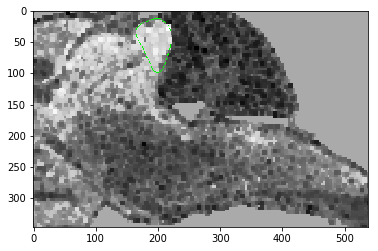

In [55]:
# figure(figsize=[8,8])
com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 30, lineType=8)
imshow(com[::32,::32])
cv2.imwrite(os.environ['ROOT_DIR']+filename, com[::32,::32])

In [56]:
len(grid_features.keys())

15354